In [27]:
from typing_extensions import TypedDict, Literal

from langgraph.types import Command
from langgraph.graph import StateGraph, START, END

from langchain.chat_models import init_chat_model
from pydantic import BaseModel

llm = init_chat_model("openai:gpt-5-nano")

dumb_llm = init_chat_model("openai:gpt-3.5-turbo")
average_llm = init_chat_model("openai:gpt-4o")
dumb_llm = init_chat_model("openai:gpt-5-2025-08-07")

In [28]:
class State(TypedDict):
    question: str
    difficulty: str
    answer: str
    model_used: str


class DifficultyResponse(BaseModel):
    difficulty_level: Literal["easy", "medium", "hard"]

In [29]:
def assess_difficulty(state: State):
    structured_llm = llm.with_structured_output(DifficultyResponse)

    assess_res = structured_llm.invoke(
        f"""
        Assess the difficulty of this question
        Question: {state["question"]}

         - EASY : simple facts, basic definitions, yes/no anwers
         - MEDIUM : Requires explanation, compariosn, analysis
         - HARD : Complex reasioning, Multiple steps, deep experties.

        """
    )
    difficulty_level = assess_res.difficulty_level
    goto = "assess_difficulty"

    if difficulty_level == "easy":
        goto = "dumb_node"
    elif difficulty_level == "medium":
        goto = "average_node"
    elif difficulty_level == "hard":
        goto = "smart_node"

    return Command(
        goto=goto,
        update={
            "difficulty": difficulty_level,
        }
    )


def dumb_node(state: State):
    easy_res = dumb_llm.invoke(state["question"])
    return {
        "answer": easy_res.content,
        "model_used": "gpt-3.5"
    }


def average_node(state: State):
    med_res = average_llm.invoke(state["question"])
    return {
        "answer": med_res.content,
        "model_used": "gpt-4o"
    }


def smart_node(state: State):
    hard_res = dumb_llm.invoke(state["question"])
    return {
        "answer": hard_res.content,
        "model_used": "gpt-5"
    }



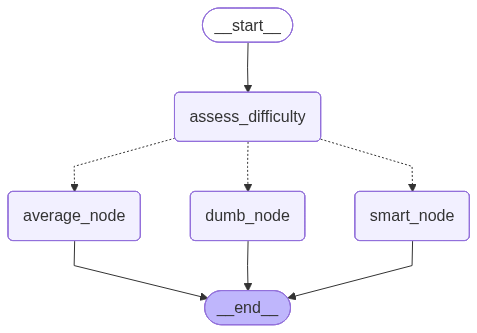

In [30]:
graph_builder = StateGraph(State)
(
    graph_builder
    .add_node("assess_difficulty", assess_difficulty,
              destinations={
                  "dumb_node",
                  "average_node",
                  "smart_node"
              })
    .add_node("dumb_node", dumb_node)
    .add_node("average_node", average_node)
    .add_node("smart_node", smart_node)

    .add_edge(START, "assess_difficulty")
    .add_edge("dumb_node", END)
    .add_edge("average_node", END)
    .add_edge("smart_node", END)
)

graph = graph_builder.compile()

display(graph)

In [31]:
graph.invoke({
    "question" : "what is your name?>"
})

{'question': 'what is your name?>',
 'difficulty': 'easy',
 'answer': 'I’m an AI assistant. You can call me ChatGPT. How can I help you today?',
 'model_used': 'gpt-3.5'}

In [32]:
graph.invoke({
    "question" : "can you predict of Korea population of 2026"
})

{'question': 'can you predict of Korea population of 2026',
 'difficulty': 'medium',
 'answer': "I can't provide real-time data or future predictions beyond 2023. However, I can suggest how you might approach making a population estimate for South Korea in 2026.\n\n1. **Current Trends**: Review the most recent data from sources like the Korean Statistical Information Service (KOSIS) or the United Nations World Population Prospects for trends in population growth or decline, such as birth rate, death rate, and immigration patterns.\n\n2. **Growth Rate**: Calculate the annual growth rate using historical data. If the growth rate is relatively stable, you can apply this rate to estimate future population numbers.\n\n3. **Demographic Policy**: Consider any demographic policies that might affect population growth, such as incentives for higher birth rates or changes in immigration policy.\n\n4. **Socioeconomic Factors**: Economic conditions, societal trends, and external factors (like the C

In [33]:
graph.invoke({
    "question" : "let me know trand of Samsung Stock in 2027"
})

{'question': 'let me know trand of Samsung Stock in 2027',
 'difficulty': 'hard',
 'answer': 'Do you mean:\n- The actual price trend in 2027 (year-to-date performance), or\n- An outlook/forecast for how Samsung Electronics’ stock might trend in 2027?\n\nI can’t access live 2027 data here, but here’s a concise 2027 outlook framework for Samsung Electronics (KRX:005930 / 005935, OTC: SSNLF):\n\nWhat likely drives the 2027 trend\n- Memory cycle: DRAM/DDR5/HBM demand from AI servers; supply discipline vs SK hynix/Micron.\n- HBM execution: yields, customer qualifications, and share gains/losses in HBM3E/HBM4.\n- Foundry progress: 3nm/2nm GAA yields and marquee customer wins vs TSMC.\n- Mobile and on-device AI: higher DRAM/NAND per device supporting ASPs.\n- Capex/FCF: spending on Pyeongtaek/Taylor fabs vs cash generation; dividends/buybacks.\n- FX and macro: KRW/USD, global growth, geopolitics/export controls.\n\nScenarios for 2027\n- Bull case: Strong HBM share and foundry wins; AI server 